<h2>Real or Not? NLP with Disaster Tweets</h2>

<p>This notebook consists of code and explanations on exploratory data analysis and cleaning of <a href="https://www.kaggle.com/c/nlp-getting-started/data">Disaster Tweets</a> from Kaggle Competition.</p>

<H3>Exploratory Data Analysis</H3>

<h4>Basic Information</h4>
<p>The data consists of 2 files: train.csv and test.csv</p>
<p>The train file contains five features: ID, Keyword, Location, Text and Target (Label 1 for disaster and 0 for non-disaster)</p>

In [27]:
import gc
import re
import string
import operator
from collections import defaultdict
from wordcloud import STOPWORDS
import numpy as np
import pandas as pd
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import StratifiedKFold, StratifiedShuffleSplit
from sklearn.metrics import precision_score, recall_score, f1_score
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.layers import Dense, Input, Dropout, GlobalAveragePooling1D
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, Callback

Number of rows and features in both files:

In [34]:
df_train = pd.read_csv('data/train.csv', dtype={'id': np.int16, 'target': np.int8})
df_test = pd.read_csv('data/test.csv', dtype={'id': np.int16})
print('Training Set Shape = {}'.format(df_train.shape))
print('Test Set Shape = {}'.format(df_test.shape))

Training Set Shape = (7613, 5)
Test Set Shape = (3263, 4)


Sample raw data in training set

In [35]:
df_train.head(5)

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


<h4>Missing Values</h4>
<p>0.8% of keyword is missing in both training and test set</p>
<p>33% of location is missing in both training and test set</p>

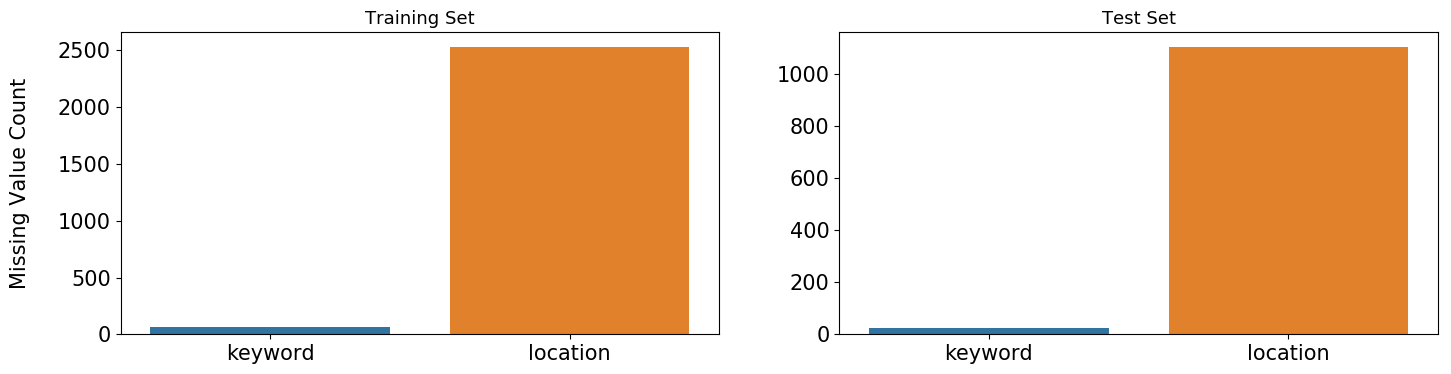

In [36]:
missing_cols = ['keyword', 'location']

fig, axes = plt.subplots(ncols=2, figsize=(17, 4), dpi=100)

sns.barplot(x=df_train[missing_cols].isnull().sum().index, y=df_train[missing_cols].isnull().sum().values, ax=axes[0])
sns.barplot(x=df_test[missing_cols].isnull().sum().index, y=df_test[missing_cols].isnull().sum().values, ax=axes[1])

axes[0].set_ylabel('Missing Value Count', size=15, labelpad=20)
axes[0].tick_params(axis='x', labelsize=15)
axes[0].tick_params(axis='y', labelsize=15)
axes[1].tick_params(axis='x', labelsize=15)
axes[1].tick_params(axis='y', labelsize=15)

axes[0].set_title('Training Set', fontsize=13)
axes[1].set_title('Test Set', fontsize=13)

plt.show()

for df in [df_train, df_test]:
    for col in ['keyword', 'location']:
        df[col] = df[col].fillna(f'no_{col}')

<h4>Distribution of Classes</h4>

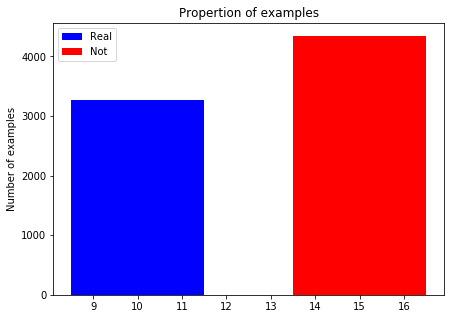

In [37]:
Real_len = df_train[df_train['target'] == 1].shape[0]
Not_len = df_train[df_train['target'] == 0].shape[0]
# bar plot of the 3 classes
plt.rcParams['figure.figsize'] = (7, 5)
plt.bar(10,Real_len,3, label="Real", color='blue')
plt.bar(15,Not_len,3, label="Not", color='red')
plt.legend()
plt.ylabel('Number of examples')
plt.title('Propertion of examples')
plt.show()

In [38]:
print("Number of real disaster tweets:", Real_len)
print("Number of non-disaster tweets:", Not_len)

Number of real disaster tweets: 3271
Number of non-disaster tweets: 4342


<h4>Number of characters of texts in both classes</h4>

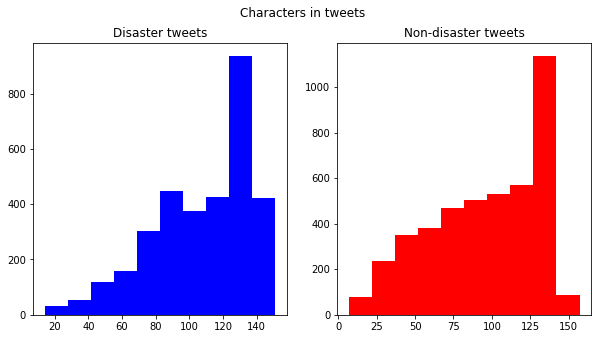

In [39]:
#get length of text for Text column
def length(text):    
    return len(text)
df_train['length'] = df_train['text'].apply(length)

fig,(ax1,ax2)=plt.subplots(1,2,figsize=(10,5))
tweet_len=df_train[df_train['target']==1]['text'].str.len()
ax1.hist(tweet_len,color='blue')
ax1.set_title('Disaster tweets')
tweet_len=df_train[df_train['target']==0]['text'].str.len()
ax2.hist(tweet_len,color='red')
ax2.set_title('Non-disaster tweets')
fig.suptitle('Characters in tweets')
plt.show()

The number of characters in both classes are roughly the same, and disaster tweets tend to have more characters within its class

<h4>N-Grams</h4>
<p>This section will explore the top 30 frequent <b>unigrams</b>, <b>bigrams</b> and <b>trigrams</b> for disaster and non-disaster tweets<p>
<p>Stop words are excluded from measuring the most frequent n-grams</p>

In [40]:
def generate_ngrams(text, n_gram=1):
    token = [token for token in text.lower().split(' ') if token != '' if token not in STOPWORDS]
    ngrams = zip(*[token[i:] for i in range(n_gram)])
    return [' '.join(ngram) for ngram in ngrams]

DISASTER_TWEETS = df_train['target'] == 1
N = 30

<h4>Unigrams</h4>

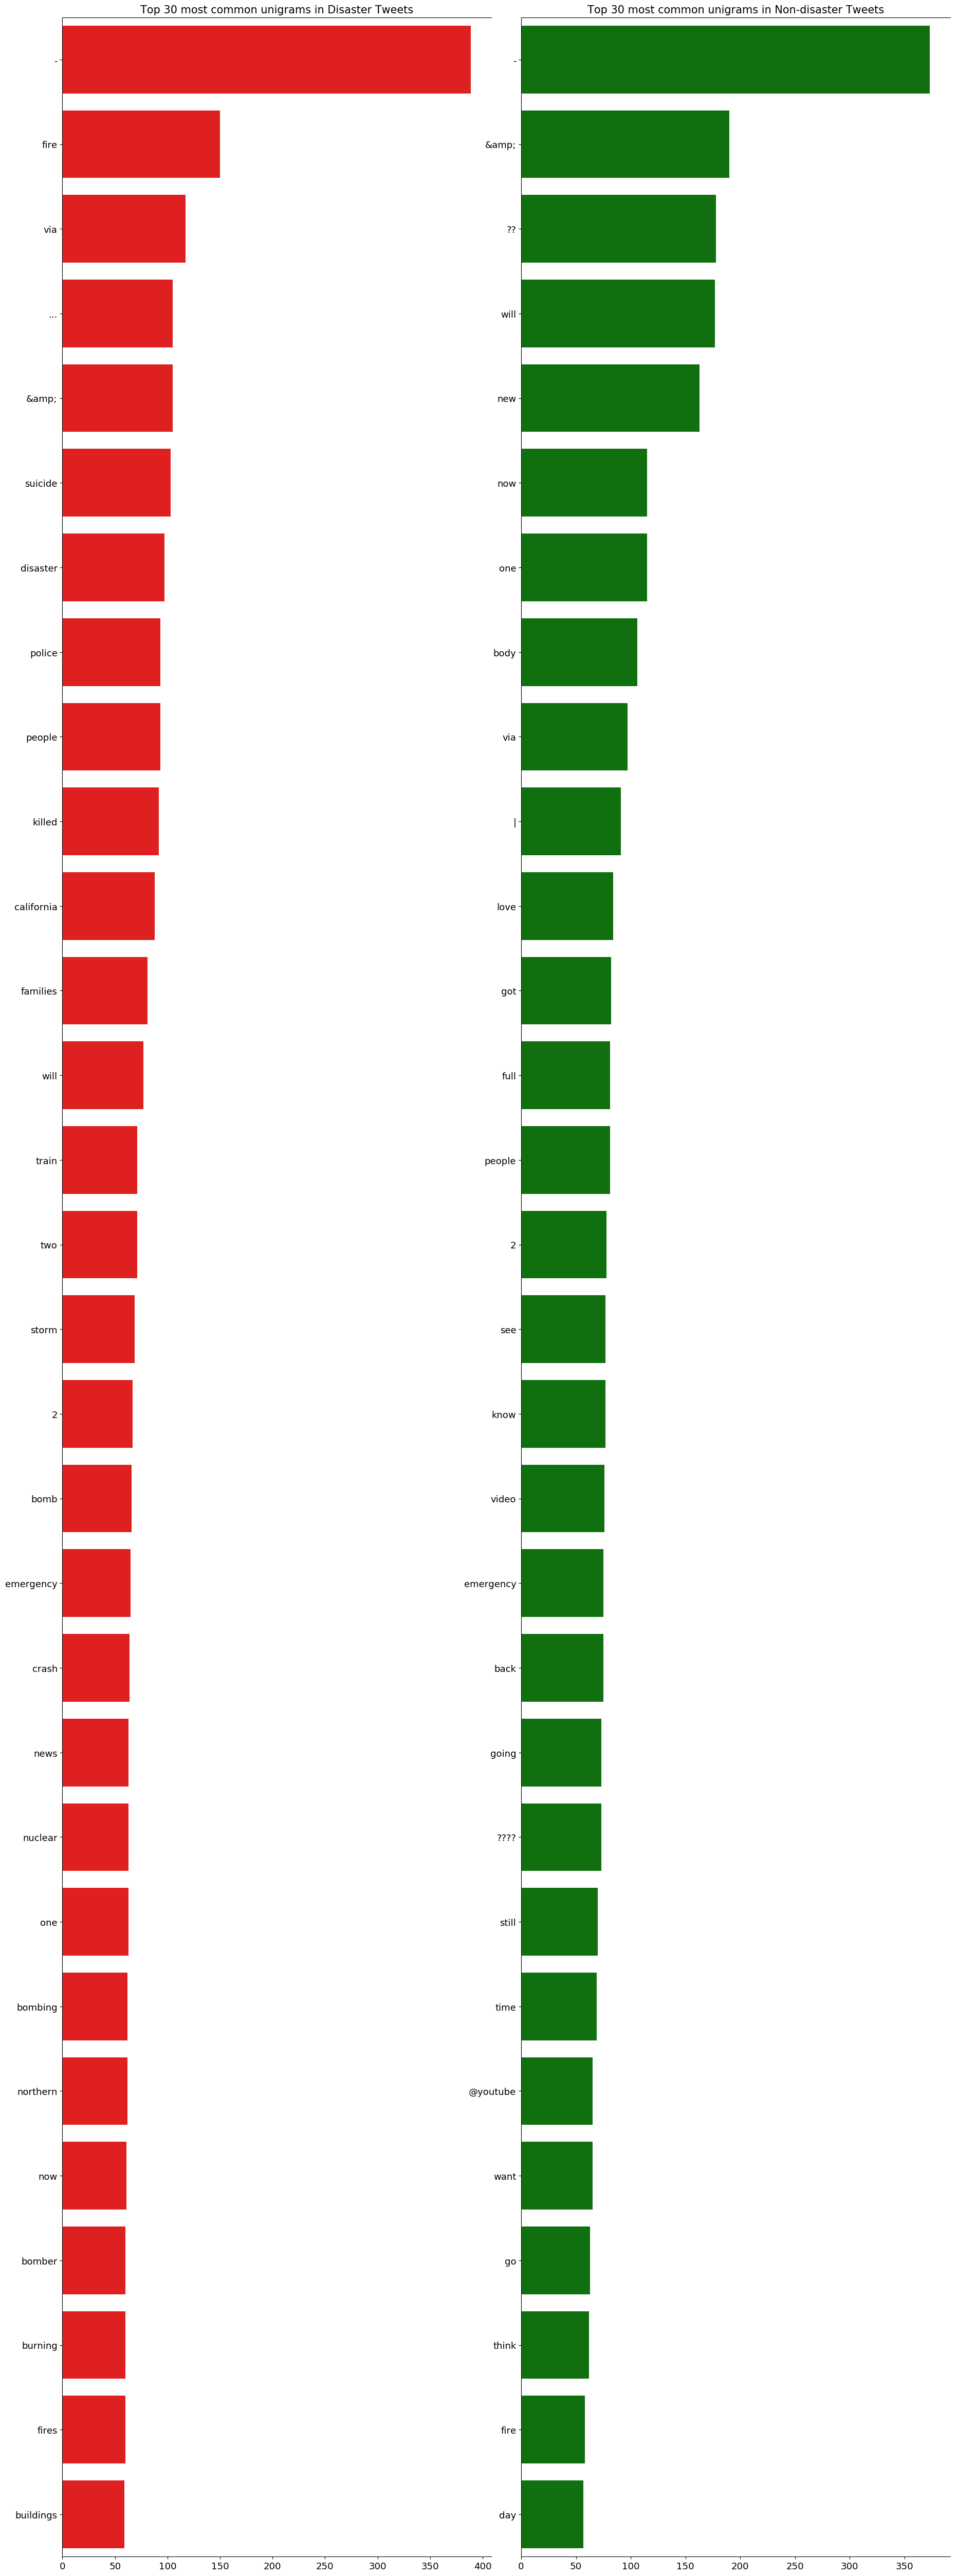

In [41]:
disaster_unigrams = defaultdict(int)
nondisaster_unigrams = defaultdict(int)

for tweet in df_train[DISASTER_TWEETS]['text']:
    for word in generate_ngrams(tweet):
        disaster_unigrams[word] += 1
        
for tweet in df_train[~DISASTER_TWEETS]['text']:
    for word in generate_ngrams(tweet):
        nondisaster_unigrams[word] += 1
        
df_disaster_unigrams = pd.DataFrame(sorted(disaster_unigrams.items(), key=lambda x: x[1])[::-1])
df_nondisaster_unigrams = pd.DataFrame(sorted(nondisaster_unigrams.items(), key=lambda x: x[1])[::-1])

fig, axes = plt.subplots(ncols=2, figsize=(18, 50), dpi=100)
plt.tight_layout()

sns.barplot(y=df_disaster_unigrams[0].values[:N], x=df_disaster_unigrams[1].values[:N], ax=axes[0], color='red')
sns.barplot(y=df_nondisaster_unigrams[0].values[:N], x=df_nondisaster_unigrams[1].values[:N], ax=axes[1], color='green')

for i in range(2):
    axes[i].spines['right'].set_visible(False)
    axes[i].set_xlabel('')
    axes[i].set_ylabel('')
    axes[i].tick_params(axis='x', labelsize=13)
    axes[i].tick_params(axis='y', labelsize=13)

axes[0].set_title(f'Top {N} most common unigrams in Disaster Tweets', fontsize=15)
axes[1].set_title(f'Top {N} most common unigrams in Non-disaster Tweets', fontsize=15)

plt.show()

<h4>Bigrams</h4>

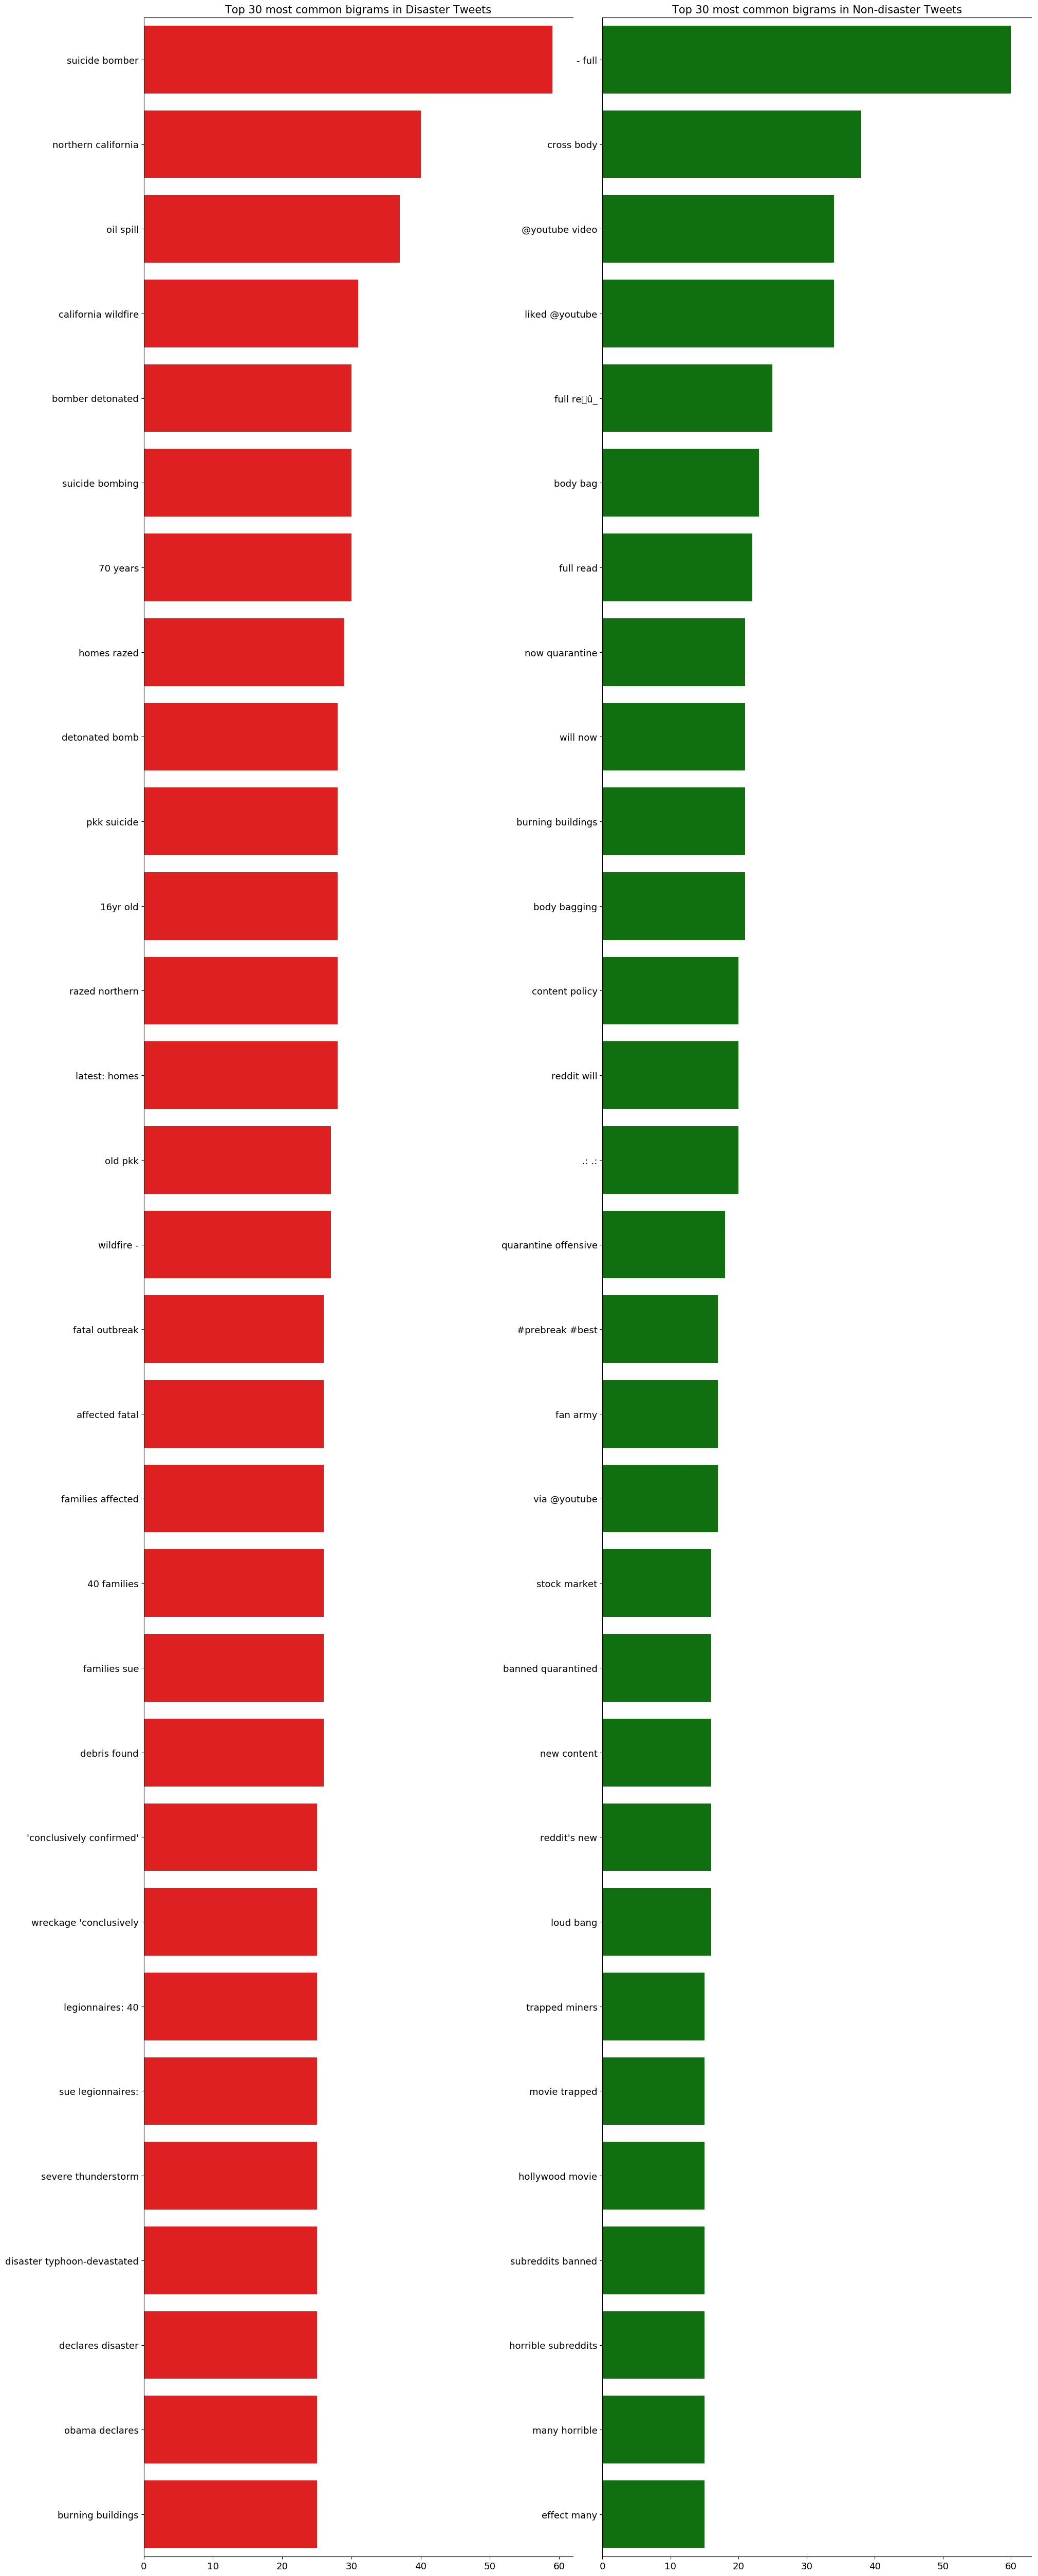

In [42]:
# Bigrams
disaster_bigrams = defaultdict(int)
nondisaster_bigrams = defaultdict(int)

for tweet in df_train[DISASTER_TWEETS]['text']:
    for word in generate_ngrams(tweet, n_gram=2):
        disaster_bigrams[word] += 1
        
for tweet in df_train[~DISASTER_TWEETS]['text']:
    for word in generate_ngrams(tweet, n_gram=2):
        nondisaster_bigrams[word] += 1
        
df_disaster_bigrams = pd.DataFrame(sorted(disaster_bigrams.items(), key=lambda x: x[1])[::-1])
df_nondisaster_bigrams = pd.DataFrame(sorted(nondisaster_bigrams.items(), key=lambda x: x[1])[::-1])

fig, axes = plt.subplots(ncols=2, figsize=(18, 50), dpi=100)
plt.tight_layout()

sns.barplot(y=df_disaster_bigrams[0].values[:N], x=df_disaster_bigrams[1].values[:N], ax=axes[0], color='red')
sns.barplot(y=df_nondisaster_bigrams[0].values[:N], x=df_nondisaster_bigrams[1].values[:N], ax=axes[1], color='green')

for i in range(2):
    axes[i].spines['right'].set_visible(False)
    axes[i].set_xlabel('')
    axes[i].set_ylabel('')
    axes[i].tick_params(axis='x', labelsize=13)
    axes[i].tick_params(axis='y', labelsize=13)

axes[0].set_title(f'Top {N} most common bigrams in Disaster Tweets', fontsize=15)
axes[1].set_title(f'Top {N} most common bigrams in Non-disaster Tweets', fontsize=15)

plt.show()

<h4>Trigrams</h4>

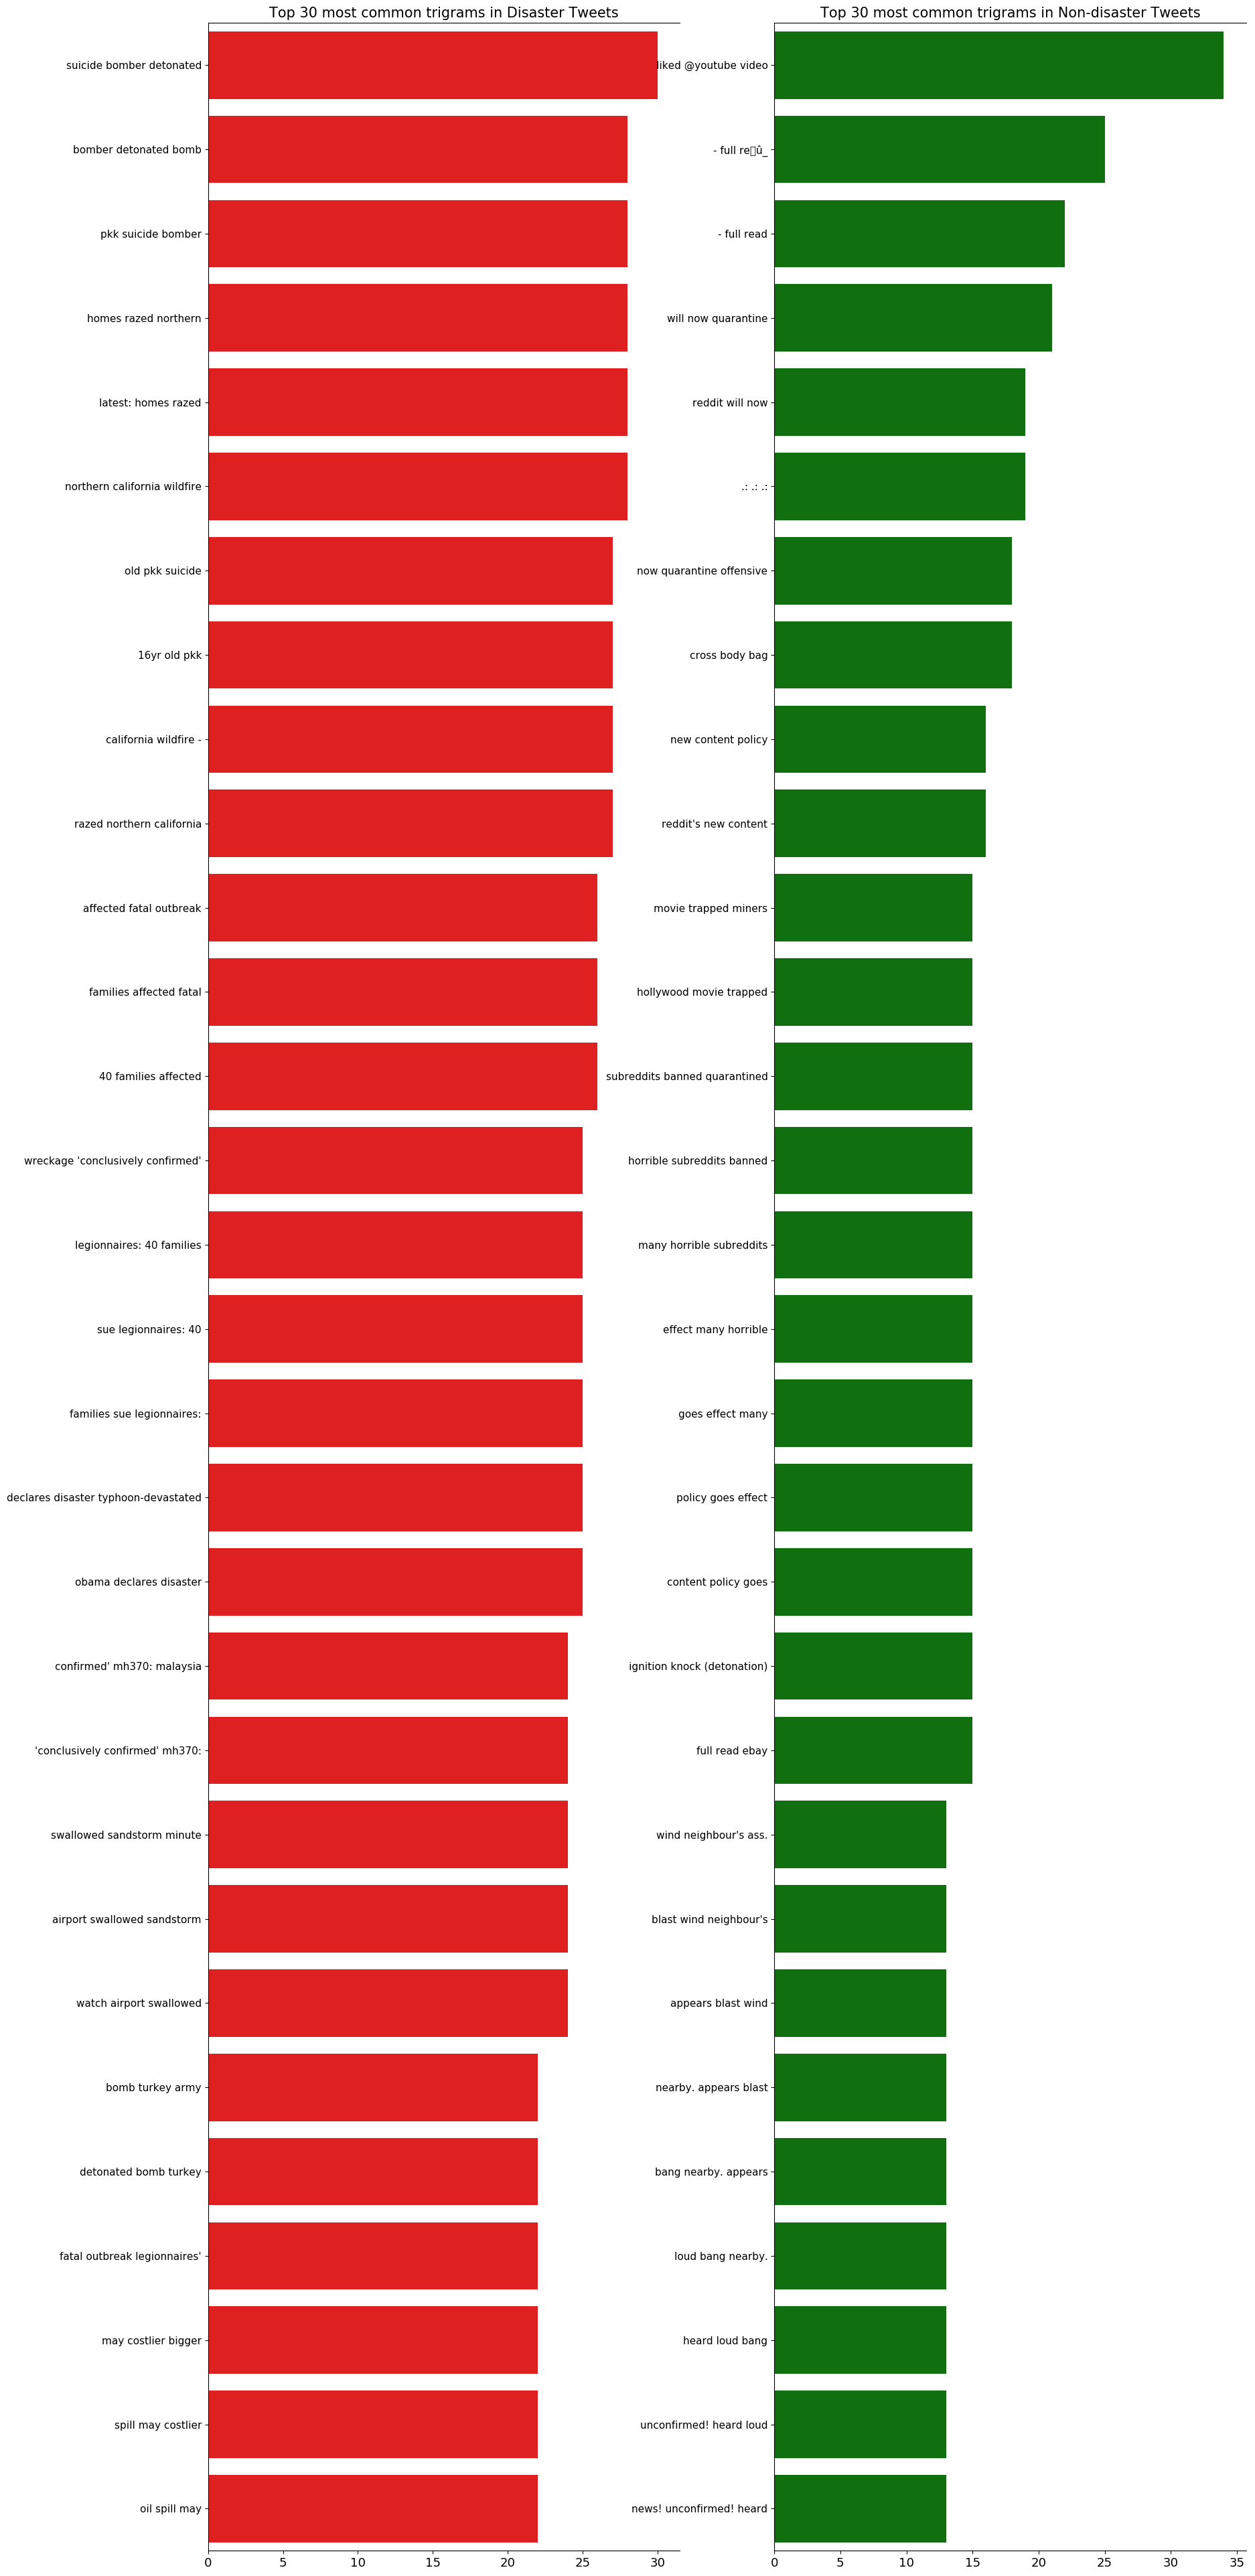

In [43]:
# Trigrams
disaster_trigrams = defaultdict(int)
nondisaster_trigrams = defaultdict(int)

for tweet in df_train[DISASTER_TWEETS]['text']:
    for word in generate_ngrams(tweet, n_gram=3):
        disaster_trigrams[word] += 1
        
for tweet in df_train[~DISASTER_TWEETS]['text']:
    for word in generate_ngrams(tweet, n_gram=3):
        nondisaster_trigrams[word] += 1
        
df_disaster_trigrams = pd.DataFrame(sorted(disaster_trigrams.items(), key=lambda x: x[1])[::-1])
df_nondisaster_trigrams = pd.DataFrame(sorted(nondisaster_trigrams.items(), key=lambda x: x[1])[::-1])

fig, axes = plt.subplots(ncols=2, figsize=(20, 50), dpi=100)

sns.barplot(y=df_disaster_trigrams[0].values[:N], x=df_disaster_trigrams[1].values[:N], ax=axes[0], color='red')
sns.barplot(y=df_nondisaster_trigrams[0].values[:N], x=df_nondisaster_trigrams[1].values[:N], ax=axes[1], color='green')

for i in range(2):
    axes[i].spines['right'].set_visible(False)
    axes[i].set_xlabel('')
    axes[i].set_ylabel('')
    axes[i].tick_params(axis='x', labelsize=13)
    axes[i].tick_params(axis='y', labelsize=11)

axes[0].set_title(f'Top {N} most common trigrams in Disaster Tweets', fontsize=15)
axes[1].set_title(f'Top {N} most common trigrams in Non-disaster Tweets', fontsize=15)

plt.show()

<H3>Data Cleaning</H3>

<p>From the EDA part above, we can see most of the key words and locations are missing from training set. Therefore, only texts are used for further classification task. The data cleaning part will focus on using regular expression to remove irrelevant information such as links, HTML tags, symbols, punctuations, stop words</p>
<p>Further cleaning focuses on lemmization, stemmerization and so on</p>

<h4>Remove Links</h4>

In [45]:
def remove_URL(text):
    url = re.compile(r'https?://\S+|www\.\S+')
    return url.sub(r'',text)

df_train['text']=df_train['text'].apply(lambda x : remove_URL(x))

<h4>Remove HTML Tags</h4>

In [47]:
def remove_html(text):
    html=re.compile(r'<.*?>')
    return html.sub(r'',text)
df_train['text']=df_train['text'].apply(lambda x : remove_html(x))

<h4>Remove Emojis/Symbols/Flags</h4>

In [48]:
def remove_emoji(text):
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)
df_train['text']=df_train['text'].apply(lambda x : remove_emoji(x))

<h4>Remove Punctuations</h4>

In [49]:
def remove_punct(text):
    table=str.maketrans('','',string.punctuation)
    return text.translate(table)

df_train['text']=df_train['text'].apply(lambda x : remove_punct(x))

<h4>Save the result</h4>

In [55]:
df_save = df_train[['id','text', 'target']]
df_save.to_csv('data/clean.csv', index=False)